In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from gurobipy import GRB
from shapely import wkt
import gurobipy as gp

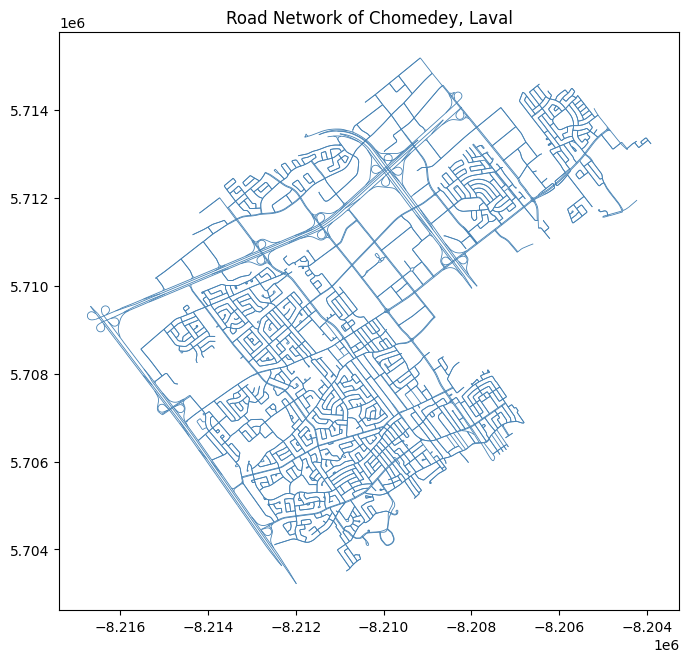

In [ ]:
# Plotting the whole network of Chomedey, Laval
edges = gpd.read_file("/content/drive/MyDrive/404_DataScienceProject/upt_laval_borough_streets.gpkg")

edges.plot(figsize=(8, 8), color="steelblue", linewidth=0.6)
plt.title("Road Network of Chomedey, Laval")
plt.show()

We will use only four streets as sample, these streets are representative of what a snow plow would usually cover in one run

In [ ]:
streets_info = {
    "SM": ("Boulevard Saint-Martin Ouest", "Boul Saint-Martin"),
    "ND": ("Boulevard Notre-Dame", "Boul Notre-Dame"),
    "CL": ("Boulevard Curé-Labelle", "Boul Curé-Labelle"),
    "MG": ("Rue Montgolfier", "Rue Montgolfier")
}

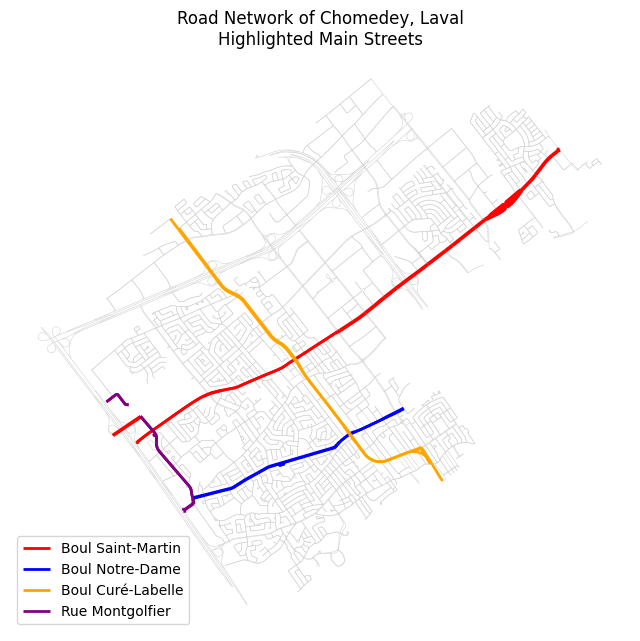

In [ ]:
# Coloring the relevant streets

colors = {
    "SM": "red",
    "ND": "blue",
    "CL": "orange",
    "MG": "purple"
}

fig, ax = plt.subplots(figsize=(8, 8))

edges.plot(ax=ax, color="lightgrey", linewidth=0.4)

# Highlight each target street
for code, (data_name, pretty_label) in streets_info.items():
    mask = edges["name"] == data_name
    if mask.any():
        edges[mask].plot(
            ax=ax,
            linewidth=2,
            color=colors.get(code, "black"),
            label=pretty_label
        )

ax.set_title("Road Network of Chomedey, Laval\nHighlighted Main Streets")
ax.set_axis_off()
ax.legend(loc="lower left")

plt.show()

We define all necessary hard-coded variables

In [ ]:
street_col = "name"  # column in `edges` to match against full OSM name

lanes = {
    "SM": 2,
    "ND": 2,
    "CL": 2,
    "MG": 1
} # Number of lanes per street, used for calculating both cleaning times and penatlies

utilization_rates = {
    "SM": 0.7,
    "ND": 0.8,
    "CL": 0.5,
    "MG": 0.4
} # used in calculations for penalties

capacity_per_lane = 1800  # vehicles/hour/lane
value_of_time_per_hr = 17.0  # $ per vehicle-hour

# Plow speeds (km/h) by highway class (tune if you have better numbers)
PLOW_SPEED_KPH_BY_HW_NORMAL = 25.0
PLOW_SPEED_KPH_BY_HW_SNOWSTORM = 15.0

In [ ]:
def calculate_lengths(edges: gpd.GeoDataFrame, streets_info: dict, street_col: str = "name") -> dict:
    """Ensure geometry units are meters (EPSG:3857 is fine for city scale)."""

    # We here that if formatting is not provided in the dataset, we attribute a format that is called EPSG: 4326 and standardize the lengths to meters
    if edges.crs is None:
        edges_m = edges.set_crs("EPSG:4326", allow_override=True).to_crs(3857)
    else:
        try:
            unit = (edges.crs.axis_info[0].unit_name or "").lower()
        except Exception:
            unit = ""
        edges_m = edges if ("metre" in unit or "meter" in unit) else edges.to_crs(3857)

    lengths_m = {}
    for code in streets_info.keys():
        full_name = streets_info[code][0]
        mask = edges_m[street_col] == full_name
        total_m = float(edges_m.loc[mask, "geometry"].length.sum()) if mask.any() else 0.0
        lengths_m[code] = total_m
    return lengths_m

In [ ]:
calculate_lengths(edges, streets_info, street_col=street_col)

{'SM': 28898.485541271664,
 'ND': 10913.016777854973,
 'CL': 18134.023058755418,
 'MG': 6941.277361232674}

Calculate_lengths is a function that calculates the whole length of the streets. However, our model aims to only solve for the inner intersections of the streets. Since the current lengths are too big for real-life situations. An attempt was made to calculate these revised lengths but to no avail, we were forced to use arbitrary values based on commonsense and external research:

In [ ]:
lengths_m = {'SM': 4424.88, 'ND': 2146.45, 'CL': 4589.69, 'MG': 1708.35}

Here we define compute_cleaning_time, a function that calculates the cleaning time of our snowplows, we are able to retrieve three variables: cleaning time of snowplow during regular snowy days (t_snowy), during snowstorm (t_snowstorm) and theoretical cleaning time (t_theory) which is assumed to be the same as t_snowy

In [ ]:
def compute_cleaning_time(lengths_m: dict,
                           streets_info: dict,
                           snowstorm=False,
                          custom_speed=None):

    if snowstorm:
        PLOW_SPEED_KPH_BY_HW = PLOW_SPEED_KPH_BY_HW_SNOWSTORM
    else:
        PLOW_SPEED_KPH_BY_HW = PLOW_SPEED_KPH_BY_HW_NORMAL
        if custom_speed:
          PLOW_SPEED_KPH_BY_HW = custom_speed

    cleaning_time = {}

    for code in streets_info.keys():
        L_km = lengths_m[code] / 1000.0
        dist_km = L_km * lanes[code]
        cleaning_time[code] = dist_km / PLOW_SPEED_KPH_BY_HW

    return cleaning_time

In [ ]:
t_snowy = compute_cleaning_time(lengths_m, streets_info, snowstorm=False)
t_snowstorm = compute_cleaning_time(lengths_m, streets_info, snowstorm=True)

t_theory = t_snowy

print("Regular Snow Day (t_snowy + t_theory) in hours:", t_snowy)
print("Snowstorm Day (t_snowstorm) in hours:", t_snowstorm)

Regular Snow Day (t_snowy + t_theory) in hours: {'SM': 0.3539904, 'ND': 0.17171599999999998, 'CL': 0.3671751999999999, 'MG': 0.06833399999999999}
Snowstorm Day (t_snowstorm) in hours: {'SM': 0.589984, 'ND': 0.2861933333333333, 'CL': 0.6119586666666665, 'MG': 0.11388999999999999}


In [ ]:
def penalty(streets_info, lengths_m, peak=False, criticality_mult=1.0, criticality_code=None):
    """
    Compute $/min penalties per street.
    If `criticality_code` is set (e.g., "CL"), only that street gets multiplied by `criticality_mult`.
    This scenario is used to simulate critical infrastructure.
    """
    streets = list(streets_info.keys())
    peak_rate = 1.5 if peak else 1.0
    penalties = {}

    for code in streets:
        flow = lanes[code] * capacity_per_lane * utilization_rates[code] * peak_rate
        base = (lengths_m[code] / 1000.0) * flow * value_of_time_per_hr * 0.01  # scaling to keep magnitudes reasonable
        penalties[code] = base * (criticality_mult if code == criticality_code else 1.0)

    return penalties

In [ ]:
penalties_off_peak = penalty(streets_info, lengths_m, peak=False)
penalties_peak = penalty(streets_info, lengths_m, peak=True)

In [ ]:
print("Off-peak penalties in $/h:", penalties_off_peak)
print("Peak penalties in $/h:", penalties_peak)

Off-peak penalties in $/h: {'SM': 1895.618592, 'ND': 1050.9019199999998, 'CL': 1404.44514, 'MG': 209.10204}
Peak penalties in $/h: {'SM': 2843.4278879999997, 'ND': 1576.3528799999997, 'CL': 2106.6677099999997, 'MG': 313.65306}


In [ ]:
streets = list(streets_info.keys())
pretty_name = {k: v[1] for k, v in streets_info.items()}

def solve_and_report(penalties: dict, t_actual: dict, t_theory: dict, label: str):
    streets = list(t_actual.keys())
    n = len(streets)

    M_act = sum(t_actual.values()) + 1.0
    M_the = sum(t_theory.values()) + 1.0

    m = gp.Model(f"snow_optA_fixedPred_{label}")

    # Variables
    S     = m.addVars(streets, lb=0, name="Start")        # actual start
    C     = m.addVars(streets, lb=0, name="Comp")         # actual completion
    S_the = m.addVars(streets, lb=0, name="StartThe")     # baseline start (the = theoretical)
    C_the = m.addVars(streets, lb=0, name="CompThe")      # baseline completion (the = theoretical)
    L     = m.addVars(streets, lb=0, name="Late")         # lateness
    z     = m.addVars(streets, streets, vtype=GRB.BINARY, name="z")   # order (i before j)
    f     = m.addVars(streets, vtype=GRB.BINARY, name="first")        # which is first (baseline)
    y     = m.addVars(streets, streets, vtype=GRB.BINARY, name="pred")# i is immediate pred of j (baseline)

    # Completion definitions
    for i in streets:
        m.addConstr(C[i]     == S[i]     + t_actual[i], name=f"C_def[{i}]")
        m.addConstr(C_the[i] == S_the[i] + t_theory[i], name=f"Cthe_def[{i}]")

    # # Single plow: if i precedes j (z[i,j]=1), j can only start after i finishes.
    for i in streets:
        for j in streets:
            if i == j:
                continue
            m.addConstr(S[j] >= C[i] - M_act*(1 - z[i,j]), name=f"seq_act[{i}->{j}]")
    for a in range(n):
        for b in range(a+1, n):
            i, j = streets[a], streets[b]
            m.addConstr(z[i,j] + z[j,i] == 1, name=f"order[{i},{j}]")

    # Pick exactly one “first street” (the one with f[i]=1) so the baseline schedule has a single starter at time 0.
    m.addConstr(gp.quicksum(f[i] for i in streets) == 1, name="one_first")

    # If i is first, it must be before everyone else
    for i in streets:
        for j in streets:
            if i == j:
                continue
            m.addConstr(z[i,j] >= f[i], name=f"first_order_link[{i}->{j}]")

    # Anchor: S_the[first] = 0 ; for others S_the >= 0 already
    for i in streets:
        m.addConstr(S_the[i] <= M_the * (1 - f[i]), name=f"first_anchor[{i}]")

    # - Making sure that no one is predecessor of itself
    for i in streets:
        m.addConstr(y[i,i] == 0, name=f"no_self_pred[{i}]")

    # - Making sure that each non-first j has exactly one immediate predecessor
    for j in streets:
        m.addConstr(gp.quicksum(y[i,j] for i in streets if i != j) == 1 - f[j], name=f"one_pred[{j}]")

    # Making sure that only someone that is before j in z can be its immediate predecessor
    for i in streets:
        for j in streets:
            if i == j:
                continue
            m.addConstr(y[i,j] <= z[i,j], name=f"pred_implies_before[{i}->{j}]")

    # Tightness: if y[i,j]=1 then S_the[j] == C_the[i]
    for i in streets:
        for j in streets:
            if i == j:
                continue
            m.addConstr(S_the[j] >= C_the[i] - M_the*(1 - y[i,j]), name=f"tight_lb[{i}->{j}]")
            m.addConstr(S_the[j] <= C_the[i] + M_the*(1 - y[i,j]), name=f"tight_ub[{i}->{j}]")

    # Lateness = extra delay vs tight, anchored baseline
    for i in streets:
        m.addConstr(L[i] >= C[i] - C_the[i], name=f"L_def[{i}]")

    # 5) Objective
    m.setObjective(gp.quicksum(penalties[i] * L[i] for i in streets), GRB.MINIMIZE)

    m.optimize()

    print(f"Scenario: {label}")

    if m.Status in [GRB.OPTIMAL, GRB.SUBOPTIMAL, GRB.TIME_LIMIT] and m.SolCount > 0:
        # Pretty names if available
        try:
            names = {k: pretty_name[k] for k in streets}
        except Exception:
            names = {k: k for k in streets}

        print(f"\nTotal penalty (objective): {m.ObjVal:,.2f} $")

        # Order streets by actual start time
        order = sorted(streets, key=lambda k: S[k].X)

        print("\nItinerary (actual start → finish):")
        for idx, i in enumerate(order, start=1):
            print(f"  {idx}. {names[i]}: {S[i].X:.2f}h → {C[i].X:.2f}h  | late={L[i].X:.2f}h")

        print("\nBaseline (theoretical) finish times (same order, no waiting):")
        for idx, i in enumerate(order, start=1):
            print(f"  {idx}. {names[i]}: finishes at {C_the[i].X:.2f}h (theory={t_theory[i]:.2f}h, actual={t_actual[i]:.2f}h)")
    else:
        print(f"No solution. Status={m.Status}, SolCount={m.SolCount}")

In [ ]:
solve_and_report(penalties_off_peak, t_actual=t_snowy, t_theory=t_theory, label=f"Normal Snowy Day (snowstorm=False), off-peak")

Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 91 rows, 56 columns and 228 nonzeros (Min)
Model fingerprint: 0x81dfd689
Model has 4 linear objective coefficients
Variable types: 20 continuous, 36 integer (36 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [2e+02, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-02, 2e+00]
Found heuristic solution: objective 353.8489566
Presolve removed 18 rows and 22 columns
Presolve time: 0.00s
Presolved: 73 rows, 34 columns, 220 nonzeros
Variable types: 12 continuous, 22 integer (22 binary)

Root relaxation: objective 0.000000e+00, 18 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumben

In [ ]:
solve_and_report(penalties_off_peak, t_actual=t_snowstorm, t_theory=t_theory, label=f"Snowstorm Day (snowstorm=True), off-peak")

Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 91 rows, 56 columns and 228 nonzeros (Min)
Model fingerprint: 0xa9685f99
Model has 4 linear objective coefficients
Variable types: 20 continuous, 36 integer (36 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [2e+02, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-02, 3e+00]
Found heuristic solution: objective 2171.5007347
Presolve removed 18 rows and 22 columns
Presolve time: 0.00s
Presolved: 73 rows, 34 columns, 220 nonzeros
Variable types: 12 continuous, 22 integer (22 binary)

Root relaxation: objective 0.000000e+00, 25 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbe

In [ ]:
solve_and_report(penalties_peak, t_actual=t_snowy, t_theory=t_theory, label=f"Normal Snowy Day (snowstorm=False), on-peak")

Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 91 rows, 56 columns and 228 nonzeros (Min)
Model fingerprint: 0xc5c99134
Model has 4 linear objective coefficients
Variable types: 20 continuous, 36 integer (36 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [3e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-02, 2e+00]
Found heuristic solution: objective 530.7734349
Presolve removed 18 rows and 22 columns
Presolve time: 0.01s
Presolved: 73 rows, 34 columns, 220 nonzeros
Variable types: 12 continuous, 22 integer (22 binary)

Root relaxation: objective 0.000000e+00, 18 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumben

In [ ]:
solve_and_report(penalties_peak, t_actual=t_snowstorm, t_theory=t_theory, label=f"Snowstorm Day (snowstorm=True), on-peak")

Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 91 rows, 56 columns and 228 nonzeros (Min)
Model fingerprint: 0xa056d219
Model has 4 linear objective coefficients
Variable types: 20 continuous, 36 integer (36 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [3e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-02, 3e+00]
Found heuristic solution: objective 3257.2511021
Presolve removed 18 rows and 22 columns
Presolve time: 0.00s
Presolved: 73 rows, 34 columns, 220 nonzeros
Variable types: 12 continuous, 22 integer (22 binary)

Root relaxation: objective 0.000000e+00, 25 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbe

Sensitivity Analysis 1:

* Now that we have calculated the four main scenarios of our initial analysis. We want to perform a sensitivity analysis and see what happens if the model experiences a lighter or heavier snowstorm? We will assume 20km/h for the lighter snowstorm plowing speed and 10km/h for a heavier snowstorm and analyze the results on the objective function.

In [ ]:
t_light_snowstorm = compute_cleaning_time(lengths_m=lengths_m, streets_info=streets_info, snowstorm=False, custom_speed=20.0)
t_heavy_snowstorm = compute_cleaning_time(lengths_m=lengths_m, streets_info=streets_info, snowstorm=False, custom_speed=10.0)

print("Light snowstorm cleaning time in h: ", t_light_snowstorm)
print("Heavy snowstorm cleaning time in h: ", t_heavy_snowstorm)

Light snowstorm cleaning time in h:  {'SM': 0.442488, 'ND': 0.21464499999999997, 'CL': 0.4589689999999999, 'MG': 0.0854175}
Heavy snowstorm cleaning time in h:  {'SM': 0.884976, 'ND': 0.42928999999999995, 'CL': 0.9179379999999998, 'MG': 0.170835}


In [ ]:
solve_and_report(penalties_off_peak, t_actual=t_light_snowstorm, t_theory=t_theory,label=f"Light Snowstorm Day, off-peak")

Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 91 rows, 56 columns and 228 nonzeros (Min)
Model fingerprint: 0x97852e63
Model has 4 linear objective coefficients
Variable types: 20 continuous, 36 integer (36 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [2e+02, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-02, 2e+00]
Found heuristic solution: objective 1023.4719428
Presolve removed 18 rows and 22 columns
Presolve time: 0.00s
Presolved: 73 rows, 34 columns, 220 nonzeros
Variable types: 12 continuous, 22 integer (22 binary)

Root relaxation: objective 0.000000e+00, 21 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbe

In [ ]:
solve_and_report(penalties_off_peak, t_actual=t_heavy_snowstorm, t_theory=t_theory,label=f"Heavy Snowstorm Day, off-peak")

Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 91 rows, 56 columns and 228 nonzeros (Min)
Model fingerprint: 0x4e9f08b4
Model has 4 linear objective coefficients
Variable types: 20 continuous, 36 integer (36 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [2e+02, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-02, 3e+00]
Found heuristic solution: objective 4509.3380523
Presolve removed 18 rows and 22 columns
Presolve time: 0.00s
Presolved: 73 rows, 34 columns, 220 nonzeros
Variable types: 12 continuous, 22 integer (22 binary)

Root relaxation: objective 0.000000e+00, 23 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbe

In [ ]:
solve_and_report(penalties=penalties_peak, t_actual=t_light_snowstorm, t_theory=t_theory, label="Light Snowstorm Day, peak")

Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 91 rows, 56 columns and 228 nonzeros (Min)
Model fingerprint: 0xf550e4de
Model has 4 linear objective coefficients
Variable types: 20 continuous, 36 integer (36 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [3e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-02, 2e+00]
Found heuristic solution: objective 1535.2079143
Presolve removed 18 rows and 22 columns
Presolve time: 0.00s
Presolved: 73 rows, 34 columns, 220 nonzeros
Variable types: 12 continuous, 22 integer (22 binary)

Root relaxation: objective 0.000000e+00, 21 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbe

In [ ]:
solve_and_report(penalties=penalties_peak, t_actual=t_heavy_snowstorm, t_theory=t_theory, label="Heavy Snowstorm Day, peak")

Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 91 rows, 56 columns and 228 nonzeros (Min)
Model fingerprint: 0x553c84f7
Model has 4 linear objective coefficients
Variable types: 20 continuous, 36 integer (36 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [3e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-02, 3e+00]
Found heuristic solution: objective 6764.0070785
Presolve removed 18 rows and 22 columns
Presolve time: 0.00s
Presolved: 73 rows, 34 columns, 220 nonzeros
Variable types: 12 continuous, 22 integer (22 binary)

Root relaxation: objective 0.000000e+00, 23 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbe

Sensitivity Analysis 2:

* The second sensitivity analysis is focusing on a scenario in which we have critical infrastructures such as school and/or hospitals. In which case, penalty will need to be significantly higher than other streets, this translates in an aritifically inflated penalty rate for one street over the three other ones. We will assume that Boulevard Curé-Labelle has critical infrastructure hence doubling its penalty.

In [ ]:
penalties_CL_Infra_off_peak = penalty(streets_info=streets_info, lengths_m=lengths_m, peak=False, criticality_mult=2.0,criticality_code="CL")
print(penalties_CL_Infra_off_peak)
penalties_CL_Infra_peak = penalty(streets_info=streets_info, lengths_m=lengths_m, peak=True, criticality_mult=2.0,criticality_code="CL")
print(penalties_CL_Infra_peak)

{'SM': 1895.618592, 'ND': 1050.9019199999998, 'CL': 2808.89028, 'MG': 209.10204}
{'SM': 2843.4278879999997, 'ND': 1576.3528799999997, 'CL': 4213.335419999999, 'MG': 313.65306}


In [ ]:
solve_and_report(penalties=penalties_CL_Infra_off_peak, t_actual=t_snowstorm, t_theory=t_theory, label="Normal Snowy Day, Critical Infrastructure on CL")

Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 91 rows, 56 columns and 228 nonzeros (Min)
Model fingerprint: 0x6a84f873
Model has 4 linear objective coefficients
Variable types: 20 continuous, 36 integer (36 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [2e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-02, 3e+00]
Found heuristic solution: objective 3408.6208470
Presolve removed 18 rows and 22 columns
Presolve time: 0.01s
Presolved: 73 rows, 34 columns, 220 nonzeros
Variable types: 12 continuous, 22 integer (22 binary)

Root relaxation: objective 0.000000e+00, 25 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbe

In [ ]:
solve_and_report(penalties=penalties_CL_Infra_peak, t_actual=t_snowstorm, t_theory=t_theory, label="Normal Snowy Day, Critical Infrastructure on CL")

Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 91 rows, 56 columns and 228 nonzeros (Min)
Model fingerprint: 0x1971cc5e
Model has 4 linear objective coefficients
Variable types: 20 continuous, 36 integer (36 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [3e+02, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-02, 3e+00]
Found heuristic solution: objective 5112.9312705
Presolve removed 18 rows and 22 columns
Presolve time: 0.00s
Presolved: 73 rows, 34 columns, 220 nonzeros
Variable types: 12 continuous, 22 integer (22 binary)

Root relaxation: objective 0.000000e+00, 25 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbe